In [2]:
import math
import numpy as np
from numpy import linspace, meshgrid
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap


import ipywidgets as widgets
from ipyleaflet import Map, Heatmap, Rectangle, LayerGroup, WidgetControl, Marker

### 1. Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.

In [3]:
coord_NY = ((-74.25559, 40.49612), (-73.70001,  40.91553))

dictGrid =  pd.read_csv('regions.csv', sep=';').set_index('region').to_dict(orient='index')

In [4]:
df = pd.read_pickle('aggr_yellow_tripdata_2016-05.bin')
ser = df[['region', 'count']].groupby('region',  as_index=False)['count'].sum()

In [5]:
print('Количество ячеек, из которых в мае не было совершено ни одной поездки: {}'.format(ser[ser['count'] == 0].shape[0]))

Количество ячеек, из которых в мае не было совершено ни одной поездки: 1283


### 2. 3. Нарисуйте статическую карту Нью-Йорка.   Поставьте на карте точку там, где находится Эмпайр-Стейт-Билдинг. Поверх статической карты Нью-Йорка визуализируйте данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую вы окрашиваете каждую ячейку, показывала суммарное количество поездок такси из неё.

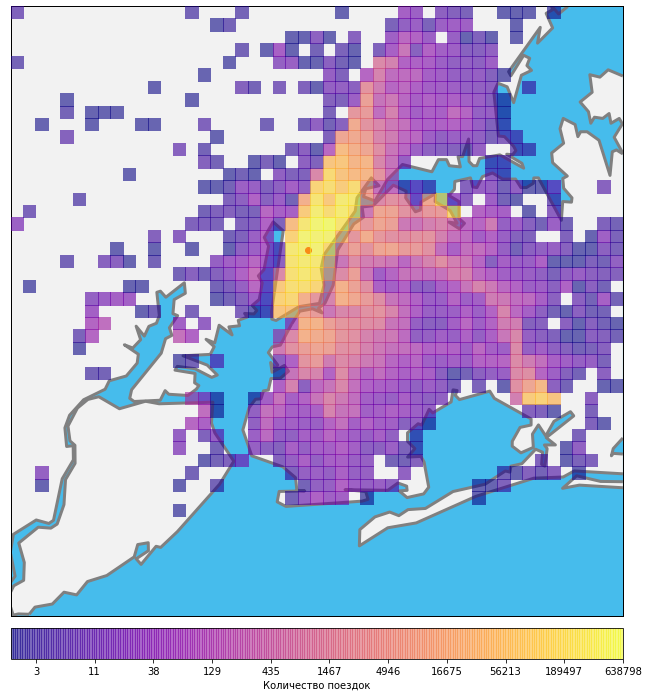

In [6]:
# Сформируем матрицу 50x50 которая будет задавать цвета.
colordata = np.transpose(ser['count'].values.reshape(50, 50))
# изображение лучше, если цвета отображаются в логарифмическом масштабе
# но надо обработать ln(0). В результате заменим и нулевые значения на nan
# Замена 0 на nan сделана для не отображения в pcolormesh нулевых значений.
colordata = np.ma.log(colordata).filled(0)
colordata[colordata == 0] = np.nan


ColorInd = plt.get_cmap('plasma')
fig = plt.figure(figsize=(12, 12))
m = Basemap(resolution='h', 
            projection='merc',
            llcrnrlon=coord_NY[0][0],
            llcrnrlat=coord_NY[0][1],
            urcrnrlon=coord_NY[1][0],
            urcrnrlat=coord_NY[1][1]
            )

m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines(color='gray', linewidth=3.0) 

lons, lats = m(-73.9856546198733, 40.7484284)
m.scatter(lons, lats, marker = 'o', color='r', zorder=5)
reg_in_water = []
# Отфильтруем квадраты, у которых все четыре угла в воде
for i in range(0, colordata.shape[0]):
    for j in range(0, colordata.shape[1]):
        if not np.isnan(colordata[j,i]):
            reg = colordata.shape[0]*i+j+1
            x1,y1 = m(dictGrid[reg]['west'], dictGrid[reg]['south'])
            x2,y2 = m(dictGrid[reg]['west'], dictGrid[reg]['north'])
            x3,y3 = m(dictGrid[reg]['east'], dictGrid[reg]['north'])
            x4,y4 = m(dictGrid[reg]['east'], dictGrid[reg]['south'])
            if not ( m.is_land(x1,y1) or m.is_land(x2,y2) or m.is_land(x3,y3) or m.is_land(x4,y4)):
                colordata[j,i] = np.nan 
                reg_in_water.append(reg)

x = linspace(0, m.urcrnrx, colordata.shape[1])
y = linspace(0, m.urcrnry, colordata.shape[0])

xx, yy = meshgrid(x, y)

colormesh = m.pcolormesh(xx, yy, colordata, cmap=ColorInd, zorder=10,  alpha=0.6)

cb = m.colorbar(colormesh, location='bottom', label="Количество поездок")
alabel =  linspace(0, np.nanmax(colordata), 12)
cb.set_ticks( alabel )
cb.set_ticklabels ([str(int(i)) for i in  np.e**alabel])


plt.show()

Посмотрим, какие ячейки были отброшены, как расположенные в воде.

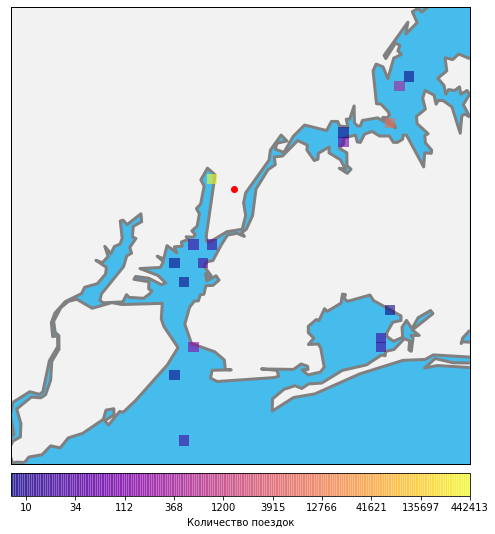

In [7]:
colordata = np.transpose(ser['count'].values.reshape(50, 50))
colordata[colordata == 0] = np.nan
ColorInd = plt.get_cmap('plasma')
fig = plt.figure(figsize=(9, 9))
m = Basemap(resolution='h', 
            projection='merc',
            llcrnrlon=coord_NY[0][0],
            llcrnrlat=coord_NY[0][1],
            urcrnrlon=coord_NY[1][0],
            urcrnrlat=coord_NY[1][1]
            )

m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines(color='gray', linewidth=3.0) 

lons, lats = m(-73.9856546198733, 40.7484284)
m.scatter(lons, lats, marker = 'o', color='r', zorder=5)
                             
for i in range(0, colordata.shape[0]):
    for j in range(0, colordata.shape[1]):
        reg = colordata.shape[0]*i+j+1
        if not(reg in reg_in_water):
            colordata[j,i] = np.nan 
            
x = linspace(0, m.urcrnrx, colordata.shape[1])
y = linspace(0, m.urcrnry, colordata.shape[0])

xx, yy = meshgrid(x, y)

colormesh = m.pcolormesh(xx, yy, colordata, cmap=ColorInd, zorder=10,  alpha=0.6)

cb = m.colorbar(colormesh, location='bottom', label="Количество поездок")
alabel =  linspace(0, np.nanmax(colordata), 12)
cb.set_ticks( alabel )
cb.set_ticklabels ([str(int(i)) for i in  np.e**alabel])

plt.show()

Как видно из рисунка выше не все отброшенные ячейки объясняются визуальным анализом.

In [8]:
print('Отброшено {} ячеек, как расположенные в воде.'.format(len(reg_in_water)))

Отброшено 17 ячеек, как расположенные в воде.


### 4, 5. Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.
### Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.

Я не совсем понял 5 пункт задания. Возможно два варианта: 
1. Одна карта похожая на карту в задании 2, на которой вместо общего количества поездок из ячейки отображено это значение, деленное на 31*24 и ограниченное порогом 5.  
2. Необходимо отобразить среднее значение поездок в час из ячейки в кажый час. Это означает, что надо сделать 24 карты (что сделано в версии, которая преобразована в html), или требуется интерактивная карта, на которой отображаеются данные за указанный час. 

#### Вариант 1

In [9]:
def draw_map(draw_group):
#     defaultLayout=Layout(width='960px', height='540px')
    m1= Map(center=[ (coord_NY[1][1] + coord_NY[0][1]) /2 , (coord_NY[1][0] + coord_NY[0][0] )/2],
            zoom = 10, zorder=10) #, layout=defaultLayout)
    rectangle = Rectangle(bounds=( (coord_NY[0][1], coord_NY[0][0]), (coord_NY[1][1], coord_NY[1][0])),
                         weight=1, fill=False)
    m1.add_layer(Marker(location=[40.689047, -74.044569], title='Статуя Свободы', draggable=False))
    m1.add_layer(rectangle)
    m1.add_layer( draw_group )
    return m1

In [10]:
ser1 = df[~df['region'].isin(reg_in_water)].groupby(['region'],  as_index=False )['count'].mean()

l_heat_data_rect_v1 = [] 
ans_6 = 0
for index, row in ser1[ser1['count'] > 5].iterrows():
    reg = row['region']
    l_heat_data_rect_v1.append( [dictGrid[reg], row['count'] ] )
    ans_6 += 1

ColorInd = plt.get_cmap('plasma')
norm_rect = matplotlib.colors.LogNorm(vmin=5, vmax=ser1['count'].max())
lgroup_v1 = LayerGroup()
for cell in l_heat_data_rect_v1:
    p0 = (cell[0]['south'], cell[0]['west'])
    p1 = (cell[0]['north'], cell[0]['east'])
    r = Rectangle( bounds = (p0, p1), fill_opacity=0.8, 
                  fill_color=matplotlib.colors.rgb2hex( ColorInd(norm_rect(cell[1]))),
                  color='black', weight=1, opacity=0.2 )  

    lgroup_v1.add_layer(r)

draw_map(lgroup_v1)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

#### Вариант 2

In [11]:
%%time
def on_value_change_rec(s):
    s.owner.Map.remove_layer(lgroup[s.old])
    s.owner.Map.add_layer( lgroup[s.new] )
    
# При формировании данных отбросим регионы, которые ранее опрделены, как находящиеся
# в воде.
df['H'] = df.datetime.dt.hour
ser1 = df[~df['region'].isin(reg_in_water)].groupby(['region', 'H'],  as_index=False )['count'].mean()

l_heat_data_rect = [ [] for i in range(0, 24)]
for i in range(0, 24):
    for index, row in ser1[ (ser1['H'] == i) & (ser1['count'] > 5) ].iterrows():
        reg = row['region']
        l_heat_data_rect[i].append( [dictGrid[reg], row['count'] ] )

Wall time: 1.14 s


In [12]:
%%time
ColorInd = plt.get_cmap('plasma')
norm_rect = matplotlib.colors.LogNorm(vmin=5, vmax=ser1['count'].max())
lgroup = [LayerGroup() for i in range(0, 24)]
for i in range(0, 24):
    print('{:3d}'.format(i), end='')
    for cell in l_heat_data_rect[i]:
        p0 = (cell[0]['south'], cell[0]['west'])
        p1 = (cell[0]['north'], cell[0]['east'])
        r = Rectangle( bounds = (p0, p1), fill_opacity=0.8, 
                      fill_color=matplotlib.colors.rgb2hex( ColorInd(norm_rect(cell[1]))),
                      color='black', weight=1, opacity=0.2 )  

        lgroup[i].add_layer(r)


  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23Wall time: 14 s


In [13]:
m_v2 = draw_map(lgroup[12])
slider = widgets.IntSlider(description='Час:', min=0, max=23, value=12)
slider.Map = m_v2
slider.observe(on_value_change_rec, names='value')
widget_control1 = WidgetControl(widget=slider, position='topright')
m_v2.add_control(widget_control1)
m_v2

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### 6. Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.

In [14]:
print('Количество ячеек, оставшихся после отбрасывания ячеек,\nиз которых в мае совершается в среднем меньше 5 поездок в час: {}'.format(ans_6))

Количество ячеек, оставшихся после отбрасывания ячеек,
из которых в мае совершается в среднем меньше 5 поездок в час: 102


### 7. Сохраните ноутбук в формате html.

Как я писал выше, для сохранения данных в html по 24 чвсам, рисуем 24 отдельные карты.

In [15]:
draw_map(lgroup[0])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [16]:
draw_map(lgroup[1])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [17]:
draw_map(lgroup[2])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [18]:
draw_map(lgroup[3])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [19]:
draw_map(lgroup[4])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [20]:
draw_map(lgroup[5])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [21]:
draw_map(lgroup[6])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [22]:
draw_map(lgroup[7])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [23]:
draw_map(lgroup[8])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [24]:
draw_map(lgroup[9])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [25]:
draw_map(lgroup[10])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [26]:
draw_map(lgroup[11])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [27]:
draw_map(lgroup[12])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [28]:
draw_map(lgroup[13])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [29]:
draw_map(lgroup[14])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [30]:
draw_map(lgroup[15])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [31]:
draw_map(lgroup[16])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [32]:
draw_map(lgroup[17])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [33]:
draw_map(lgroup[18])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [34]:
draw_map(lgroup[19])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [35]:
draw_map(lgroup[20])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [36]:
draw_map(lgroup[21])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [37]:
draw_map(lgroup[22])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [38]:
draw_map(lgroup[23])

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …